In [19]:
#from sklearn.metrics.pairwise import pairwise_distances

from itertools import product
from PIL import Image, ImageOps

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
plt = matplotlib.pyplot

%matplotlib inline

sns.set_style('whitegrid')

matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

In [2]:
image_size = (16, 16)
images_per_class = 500

In [3]:
%%time

# the directory immediately under which all the images
# reside.
file_prefix = 'data/'

# The PIL flag for grayscale.
GRAYSCALE_MODE = 'L'

# Will store tuples (id,image_data,is_dog) and then
# will be converted into the DataFrame `images`.
images_list = []

# load data/cat.0.jpg to data/cat.[images_per_class-1].jpg, 
# then data/dog.0.jpg to data/dog.[images_per_class-1].jpg.
for pet_type, index in product(['cat', 'dog'], range(images_per_class)):
    file_name = f'{pet_type}.{index}'
    
    # Load and convert to grayscale
    image = Image.open(f'{file_prefix}{file_name}.jpg').convert(mode=GRAYSCALE_MODE)
    
    # Aspect fit the image (shrink the image while maintaining
    # the aspect ratio such that the shorter dimension matches its target value
    # in image_size above. Then center it and crop off the excess to fit in
    # the dimensions of image_size).
    image = ImageOps.fit(image, image_size, method=Image.ANTIALIAS)
    
    # The PIL.ImageData object is essentially a matrix. Linearize it as a numpy array.
    data = (np.array(image.getdata())/255).astype('float32')
    
    # Add the boolean field `is_dog` as a simple representation of our cat/dog dichotomy.
    is_dog = (pet_type == 'dog')
    images_list.append((file_name,data,is_dog))

images = pd.DataFrame(data=images_list,columns=['id','image_data','is_dog'])

CPU times: user 5.66 s, sys: 153 ms, total: 5.82 s
Wall time: 6.25 s


In [4]:
images.head()

,id,image_data,is_dog
0,cat.0,"[0.803922, 0.847059, 0.741176, 0.552941, 0.419...",False
1,cat.1,"[0.188235, 0.176471, 0.188235, 0.282353, 0.301...",False
2,cat.2,"[0.792157, 0.678431, 0.537255, 0.666667, 0.380...",False
3,cat.3,"[0.65098, 0.541176, 0.498039, 0.533333, 0.6745...",False
4,cat.4,"[0.72549, 0.760784, 0.772549, 0.756863, 0.7607...",False


In [5]:
print('images stored as dtype',images.image_data[0].dtype)
print(images_per_class*2,'images,',image_size,'pixels each')
mem = images.memory_usage(deep=True).sum()
print('float64 size:',mem*2/1000000.,'MB')
print('float32 size:',mem/1000000.,'MB')

images stored as dtype float32
1000 images, (16, 16) pixels each
float64 size: 2.38572 MB
float32 size: 1.19286 MB


In [6]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson

def plot_gallery(imgs, titles, size, rows=3, cols=6):
    plt.figure(figsize = (1.7 * cols, 2.3 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        ax = plt.gca()
        [spine.set_color('black') for _,spine in ax.spines.items()]
        plt.imshow(imgs[i].reshape(size), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([]); plt.yticks([])
    plt.show()

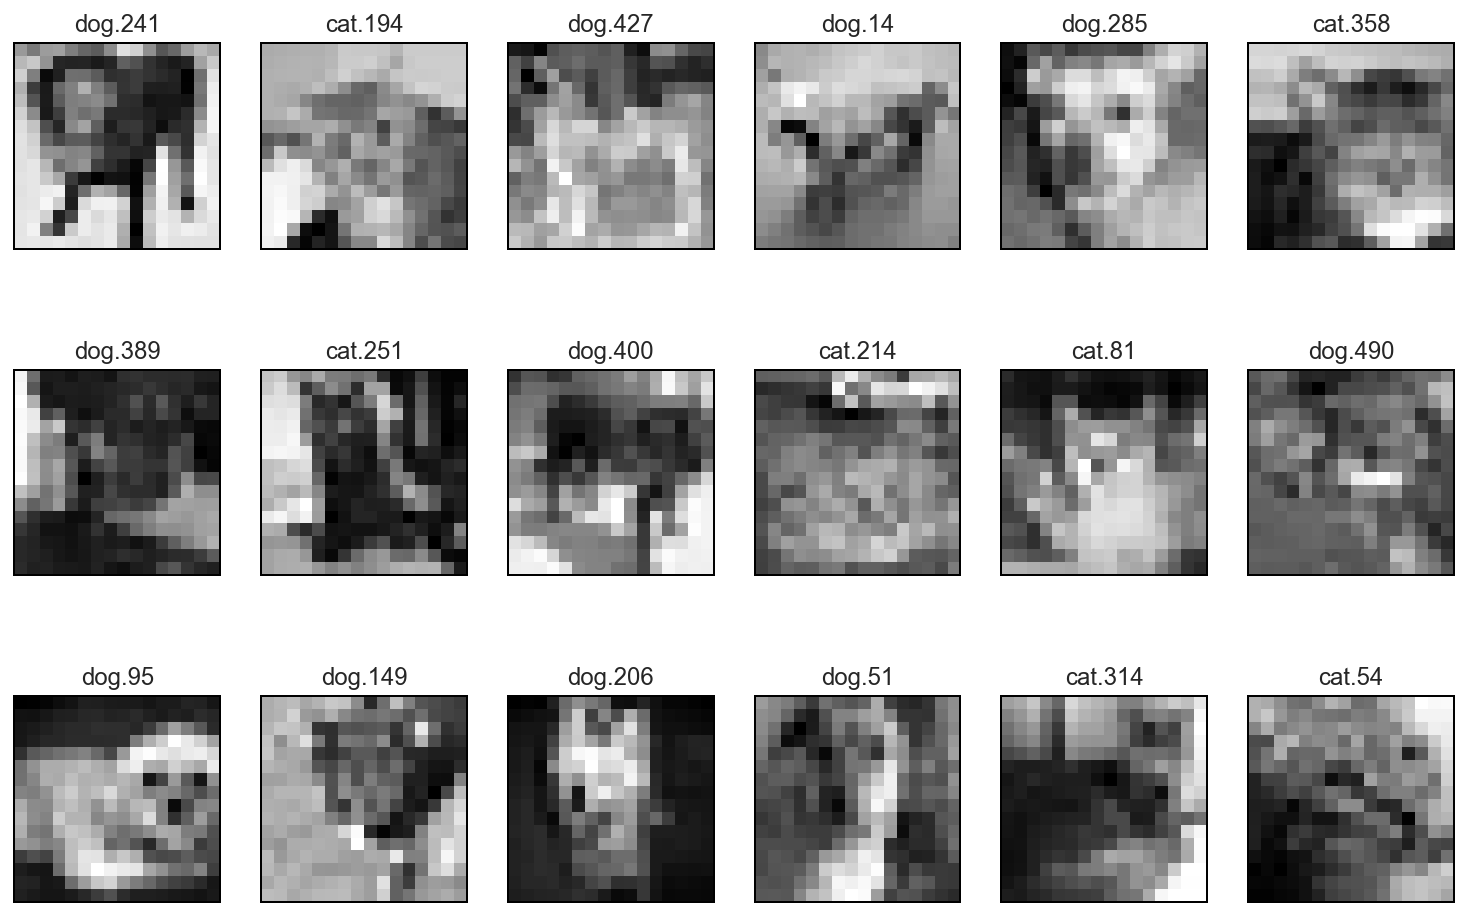

In [20]:
some_images = images.sample(n=18)
plot_gallery(some_images.image_data.iloc, some_images.id.iloc, image_size)

In [8]:
from sklearn.metrics import roc_auc_score
evaluation_function = roc_auc_score

from sklearn.model_selection import StratifiedKFold

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import Callback

class ConvolutionalNeuralNet:
    def __init__(
        self,
        input_shape,
        n_filters, 
        convolution_kernel_sizes, 
        pool_size,
        dense_sizes,
        final_dense_size,
        convolution_dropout_rate=0.0,
        dense_dropout_rate=0.0,

        convolution_activation='relu',
        dense_activation='relu',
        final_activation='softmax',

        loss='mean_squared_error', 
        optimizer='rmsprop', 
        metrics=['binary_accuracy'],

        batch_size=32,
        epochs=50,
        shuffle=False,
        verbose=2
    ):
        self.input_shape = input_shape
        self.n_filters = n_filters
        self.convolution_kernel_sizes = convolution_kernel_sizes
        self.pool_size = pool_size
        self.dense_sizes = dense_sizes
        self.final_dense_size = final_dense_size
        self.convolution_dropout_rate = convolution_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.convolution_activation = convolution_activation
        self.dense_activation = dense_activation
        self.final_activation = final_activation
        
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffle = shuffle
        self.verbose = verbose
        
        self._make_model()
    
    def _make_convolution_layers(self):
        output_size_for_dimension = lambda dim: int(self.input_shape[dim]/(self.pool_size[dim]*(i+1)))
            
        if len(self.n_filters) != len(self.convolution_kernel_sizes):
            raise ValueError('Provide the same length lists for n_filters and convolution_kernel_sizes.')
            
        self._model.add(
            Reshape(
                (1, self.input_shape[0], self.input_shape[1]), 
                input_shape=(1, self.input_shape[0]*self.input_shape[1])
            )
        )
                       
        for i in range(len(self.n_filters)):
            if output_size_for_dimension(0) == 0 or output_size_for_dimension(1) == 0:
                print("Warning: Size zero layer defined with input_shape (1,0,0). Reduce layer count")
            self._model.add(
                Conv2D(
                    filters=self.n_filters[i],
                    kernel_size=self.convolution_kernel_sizes[i],
                    padding='same',
                    activation=self.convolution_activation
                )
            )
            self._model.add(
                MaxPooling2D(pool_size=self.pool_size, data_format='channels_first')
            )
            
        self._model.add(
            Dropout(self.convolution_dropout_rate)
        )
        self._model.add(Flatten())
                
    def _make_dense_layers(self):
        for size in self.dense_sizes:
            self._model.add(
                Dense(size, activation=self.dense_activation)
            )
        self._model.add(
            Dropout(self.dense_dropout_rate)
        )
        self._model.add(
            Dense(self.final_dense_size, activation=self.final_activation)
        )
                
    def _make_model(self):
        self._model = Sequential()
        self._make_convolution_layers()
        self._make_dense_layers()
        self._model.compile(
            loss=self.loss,
            optimizer=self.optimizer,
            metrics=self.metrics
        )
                
    def fit(self, X_raw, y):
        # Using keras Callbacks to hook into end of epoch
        # for per-epoch evaluation statistics collection
        # [CITE] https://github.com/fchollet/keras/issues/2548#issuecomment-215664770
        self.epoch_log_ = []
        net = self
        class AnalyticsCallback(Callback):
            def on_epoch_end(self, epoch, logs={}):
                net.epoch_log_.append(logs)
        
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        self._model.fit(
            X, y, 
           batch_size=self.batch_size,
           epochs=self.epochs,
           shuffle=self.shuffle,
           verbose=self.verbose,
           callbacks=[AnalyticsCallback()]
        )
                       
    def predict(self, X_raw):
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        return self._model.predict(X)
    
    @staticmethod
    def one_hot_output(y_hat_raw):
        # predict() outputs floats. We want one-hot in most cases
        y_hat = np.zeros(y_hat_raw.shape, dtype=np.int)
        y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
        return y_hat

Using TensorFlow backend.


In [10]:
# we store the networks in this array
# so we can grab their epoch_log_ properties
# wherein we persist the per-epoch accuracy
# so we can make pretty charts.
def cross_validation_step(ModelClass, indices, parameters): 
    train_index, test_index = indices
    X_train = data.iloc[train_index]
    y_train = np.asarray(pd.get_dummies(target.iloc[train_index]))
    X_test = data.iloc[test_index]
    y_test = target.iloc[test_index]
    
    # training
    clf = ModelClass(**parameters)
    clf.fit(X_train, y_train)
    
    # testing
    y_hat_raw = clf.predict(X_test)
    y_hat = ModelClass.one_hot_output(y_hat_raw)
    score = evaluation_function(pd.get_dummies(y_test), y_hat)
    return score,clf

def cross_validation(ModelClass, cv, parameters):
    cv_indices = cv.split(data, target)
    scores = np.empty(n_splits)
    nets = [None]*n_splits
    
    if 'epochs' in parameters:
        total_epochs = n_splits*parameters['epochs']
        print(
            f'Performing {n_splits}-fold Stratified cross validation with {parameters["epochs"]} '
            f'epochs each ({total_epochs} epochs total)'
        )
        if total_epochs > 80:
            print('☕️ you may want to grab a coffee')
        
    # I promise I tried parallelizing this 
    # but Tensorflow didn't like it.
    #
    # (tried threading.Thread and multiprocess.Pool)
    for i,indices in enumerate(cv_indices):
        print(f'Split {i+1} of {n_splits} {"☕️"*(i+1)}')
        scores[i],nets[i] = cross_validation_step(ModelClass, indices, parameters)
        
    return scores,nets

def get_logs_from_nets(nets, parameter_name):
    return [[epoch[parameter_name] for epoch in net.epoch_log_] for net in nets]

In [14]:
params = dict(
        input_shape=image_size,
        n_filters=[64,64,64], #128 64 32 
        convolution_kernel_sizes=[(5,5),(3,3),(3,3)], 
        pool_size=(2,2),
        dense_sizes=[1024],
        final_dense_size=2,
    
        convolution_dropout_rate=.45,
        dense_dropout_rate=.65,
    
        convolution_activation='relu',
        dense_activation='relu',
        final_activation='softmax',
        
        loss='mean_squared_error', 
        optimizer='rmsprop', 
        metrics=['binary_accuracy'],
        
        batch_size=32,
        epochs=70,
        shuffle=True,
        verbose=0
)

In [15]:
%%time

data = images.image_data
target = images.is_dog

scores, nets = cross_validation(ConvolutionalNeuralNet, cv, params)

Performing 10-fold Stratified cross validation with 70 epochs each (700 epochs total)
☕️ you may want to grab a coffee
Split 1 of 10 ☕️
Split 2 of 10 ☕️☕️
Split 3 of 10 ☕️☕️☕️
Split 4 of 10 ☕️☕️☕️☕️
Split 5 of 10 ☕️☕️☕️☕️☕️
Split 6 of 10 ☕️☕️☕️☕️☕️☕️
Split 7 of 10 ☕️☕️☕️☕️☕️☕️☕️
Split 8 of 10 ☕️☕️☕️☕️☕️☕️☕️☕️
Split 9 of 10 ☕️☕️☕️☕️☕️☕️☕️☕️☕️
Split 10 of 10 ☕️☕️☕️☕️☕️☕️☕️☕️☕️☕️
CPU times: user 3min 55s, sys: 25.7 s, total: 4min 20s
Wall time: 2min 39s




Accuracy (ROC): 0.58 (±0.09)




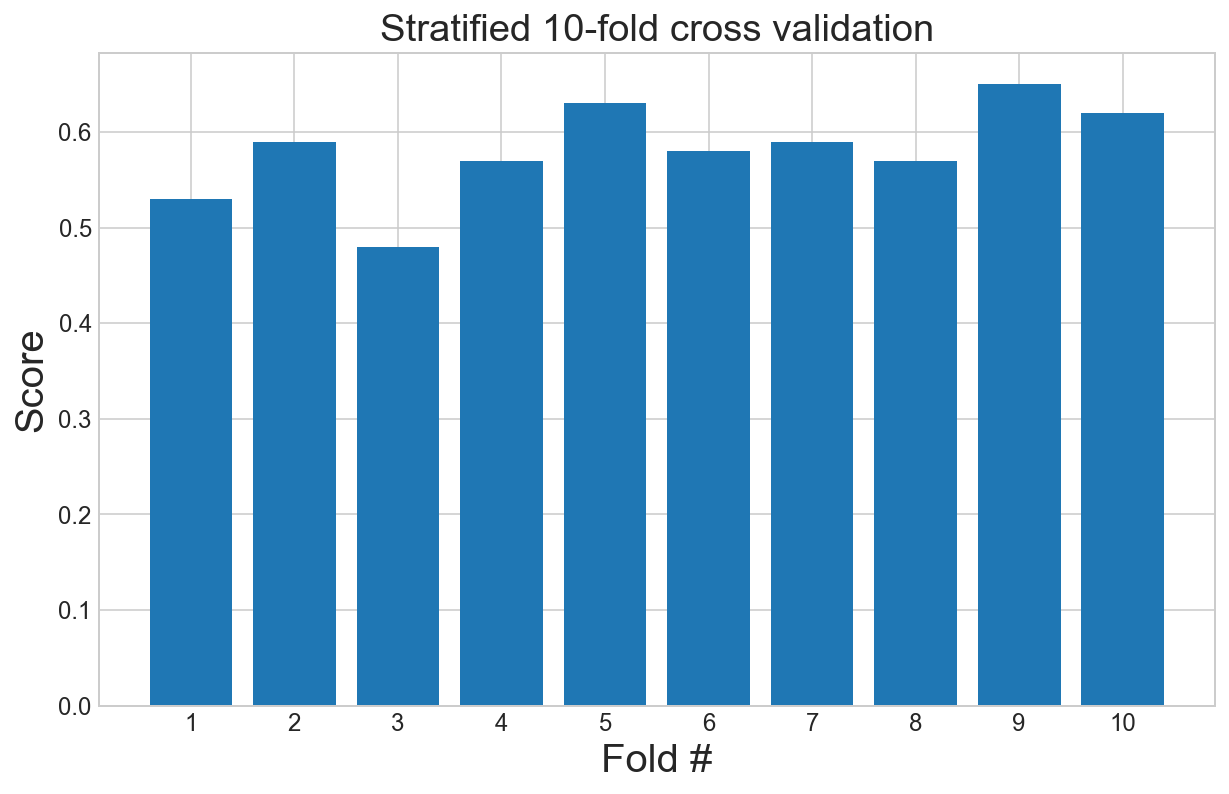

In [21]:
ax = plt.bar(range(len(scores)),scores)
plt.xticks(range(10),range(1,11))
plt.title('Stratified 10-fold cross validation')
plt.xlabel('Fold #')
plt.ylabel('Score')

print(
    '\n','='*50,'Accuracy (ROC): %0.2f (±%0.2f)' % (np.asarray(scores).mean(), np.asarray(scores).std() * 2),
    '='*50,'\n',sep='\n'
)

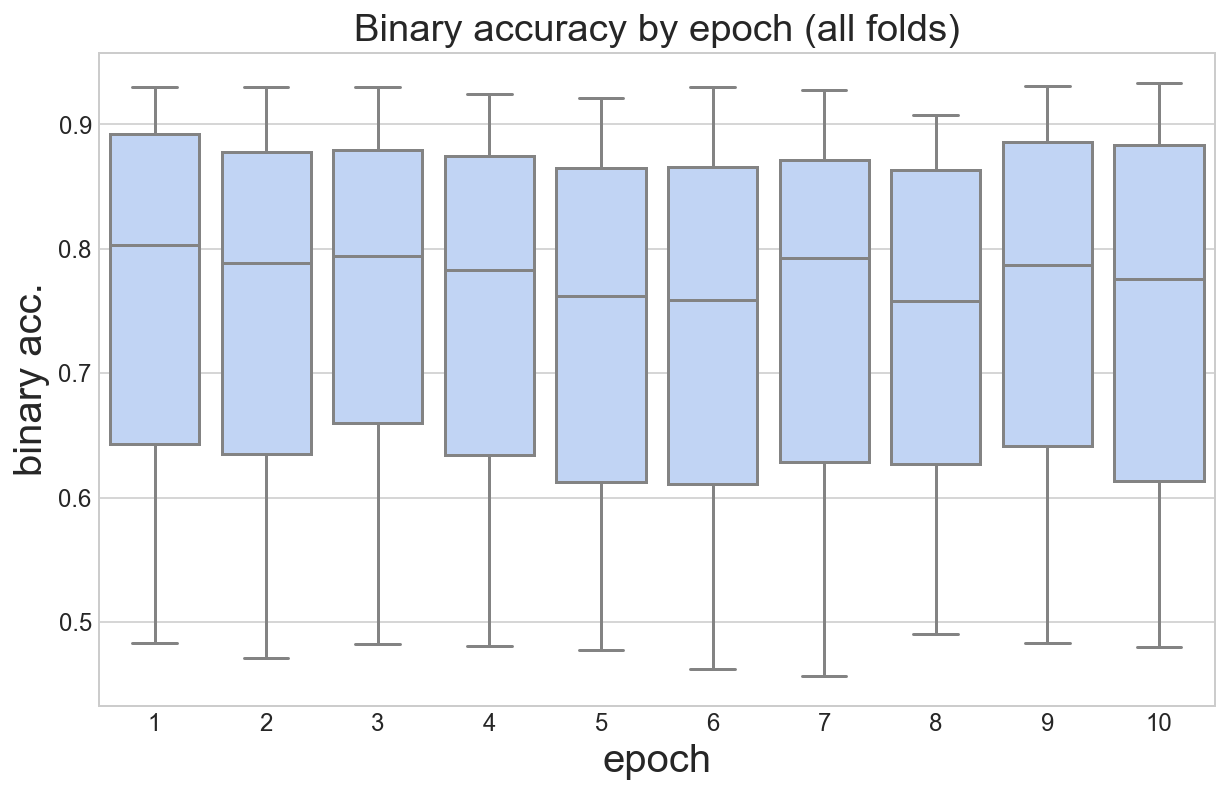

In [22]:
accs = get_logs_from_nets(nets, 'binary_accuracy')

ax = sns.boxplot(data=np.array(accs).T, color='#b8d2fc')
ax.set_xticklabels(range(1,11))
plt.xlabel('epoch')
plt.ylabel('binary acc.')
plt.title('Binary accuracy by epoch (all folds)');